In [8]:
import gains as genetic
import pandas as pd
import rdkit
from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
import numpy as np
from math import exp
import random
import unittest
import datetime

The following cell showcases the use of RDKit's similarity maps to compare candidate structures to a target structure

0.5242718446601942
CN1C=C[N+](=C1)C	0.5242718446601942	starting structure	0:00:00.007051
CCC[n+]1ccn(C)c1	0.8671328671328671	add_custom_fragment	0:00:00.035420
CC(=O)CCC[n+]1ccn(C)c1	0.8797814207650273	add_rdkit_fragment	0:00:00.045541
0.6830357142857143
starting from new parent
CC(=O)CCC[n+]1ccn(C)c1	0.8797814207650273	remove_atom	0:00:01.625044
0.6098654708520179
starting from new parent
CC(=O)CCC[n+]1ccn(C)c1	0.8797814207650273	remove_atom	0:00:03.112521
1.0
starting from new parent
0.6923076923076923
starting from new parent
CCCCC(C)n1cc[n+](C)c1	0.7725118483412322	add_custom_fragment	0:00:06.604615
CCCCCCC(C)n1cc[n+](C)c1	0.7867298578199052	add_custom_fragment	0:00:06.867844
CCCCCCCn1cc[n+](C)c1	0.9939759036144579	remove_atom	0:00:07.047344
CCCCCCCCCCn1cc[n+](C)c1	1.0	add_custom_fragment	0:00:08.074815
number of atoms: 	14
mutation attempts: 	2510


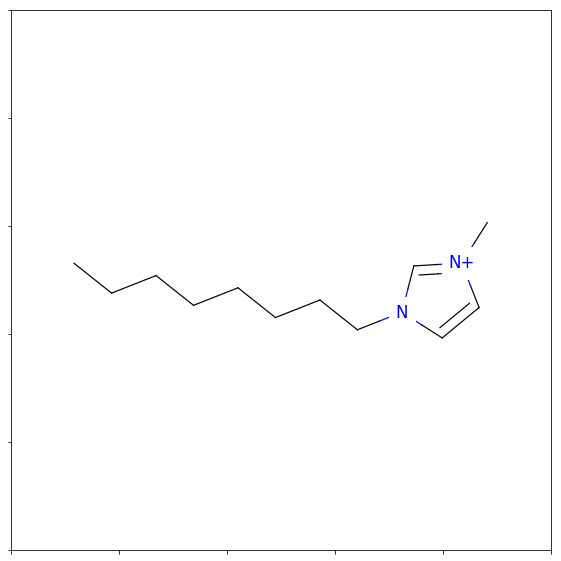

In [9]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = get_fitness(target, target)
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target)
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation, timeDiff))
    
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])

def show_ion(genes, target, mutation_attempts):
    mol = Chem.MolFromSmiles(target)
    print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    

geneSet = genetic.generate_geneset()
df = genetic.load_data("saltInfo.csv")
df = df.loc[df["cation_name"].str.contains("imid", case=False)]
df = df['cation_SMILES'].unique()
ohPickMe = random.sample(range(df.shape[0]),1)
target = df[ohPickMe[0]]
guess_password(target)
Draw.MolToMPL(Chem.MolFromSmiles(target))

Making slight changes to the above code, mainly involving the fitness function, we can use the genetic engine to search for structures of a desirable property. In this case we search for a **cation imidazole-type structure** paired with tetrafluroborate that gives a density of 800 kg/mol

0.39754713394324825
CCN1C=C[N+](=C1)C	0.39754713394324825	starting structure
CCn1c[n+](C)cc1N	0.9484909390411725	add_atom
CCc1c(N)n(CC)c[n+]1C	0.9849955740423069	add_custom_fragment
CCCCCCn1c[n+](C)c(CC)c1N	0.9872774641709502	add_custom_fragment
CCCCCn1c[n+](C)c(CC)c1N	0.9931723162738222	remove_atom
mutation attempts: 	32
within 1% of target density: 800 (kg/m) 


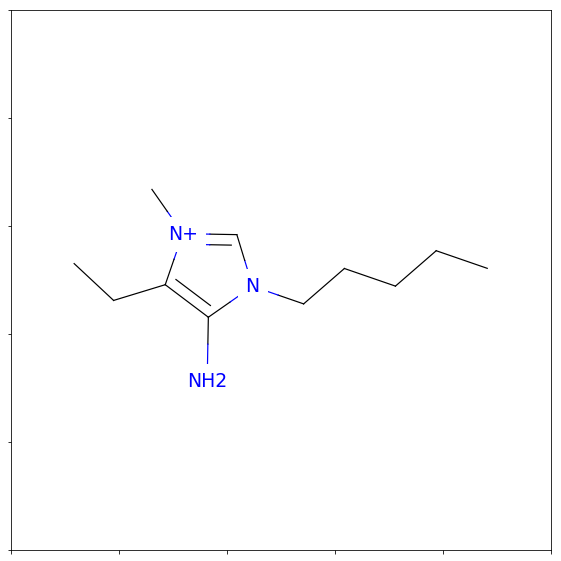

In [10]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = 0.99
    best = genetic.get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target)
    return best
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation))
    
def get_fitness(genes, target):
    cation = Chem.MolFromSmiles(genes)
    anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
    model = genetic.load_data("density_nn_model.sav", pickleFile=True)
    deslist = genetic.load_data("density_nn_model_descriptors.csv")
    feature_vector=[]
    with genetic.suppress_stdout_stderr():
        for item in deslist:
            if "anion" in item:
                feature_vector.append(calculator([item.partition('-')\
                    [0]]).CalcDescriptors(anion)[0])
            elif "cation" in item:
                feature_vector.append(calculator([item.partition('-')\
                [0]]).CalcDescriptors(cation)[0])          
            elif "Temperature_K" in item:
                feature_vector.append(298.15)
            elif "Pressure_kPa" in item:
                feature_vector.append(101.325)
            else:
                print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values
    prediction = exp(model.predict(np.array(features_normalized).reshape(1,-1))[0])
    error = abs((prediction-target)/target)
    
    return 1-error

def show_ion(genes, target, mutation_attempts):
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("within 1%% of target density: %s (kg/m) " % target)
    

geneSet = genetic.generate_geneset()
df = genetic.load_data("saltInfo.csv")
df = df.loc[df["cation_name"].str.contains("imid", case=False)]
df = df['cation_SMILES'].unique()
ohPickMe = random.sample(range(df.shape[0]),1)
target = 800
best = guess_password(target)
Draw.MolToMPL(best.Mol)